<a href="https://colab.research.google.com/github/MoeinDSP/Bittensor_Reddit_Dataset_NLP_Pipeline/blob/main/Models/4_Training_Models_Linear_classifier_sampled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1- Install and Import Libraries**

In [1]:
!pip uninstall numpy gensim -y
!pip install --force-reinstall numpy==1.24.3 gensim==4.3.0

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 243.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pyfume to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pip uninstall scipy -y
!pip install scipy==1.10.1

Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 40.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires

In [2]:
import os
import re
import json
import torch
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.serialization
import matplotlib.pyplot as plt

from numpy import ndarray
from torch import nn, optim
from itertools import product
from gensim.models import FastText
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

**2- Data Loading**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

path = '/content/drive/MyDrive/Reddit_dataset'


os.chdir(f'{path}')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1uYfTSnfokWDeAv9-_LyZu5MGDLuJlF_n/Reddit_dataset'

**3- Prepare dataset to train**

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [6]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def nltk_tokenizer(text):
    return word_tokenize(text.lower())



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, tokenizer=nltk_tokenizer, max_len=50, embedding_type='nn', embed_model=None):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        self.embedding_type = embedding_type
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.embed_model = embed_model
        self.data = self.encode_all(texts)

    def encode_text(self, text):
        tokens = self.tokenizer(text)[:self.max_len]
        if self.embedding_type == 'nn':
            ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
            ids += [self.vocab['<PAD>']] * (self.max_len - len(ids))
            return torch.tensor(ids)
        elif self.embedding_type == 'fasttext':
            emb = [self.embed_model.wv[token] if token in self.embed_model.wv else np.zeros(self.embed_model.vector_size) for token in tokens]
            if len(emb) < self.max_len:
                emb += [np.zeros(self.embed_model.vector_size)] * (self.max_len - len(emb))
            return torch.tensor(np.array(emb[:self.max_len]), dtype=torch.float32)
        else:
            raise ValueError("Unsupported embedding type")

    def encode_all(self, texts):
        return [self.encode_text(t) for t in texts]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx].float(), torch.tensor(self.labels[idx])

**4- Model Implementation**

In [8]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, use_embedding=True, dropout=0.5):
        super().__init__()
        self.use_embedding = use_embedding
        if use_embedding:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if self.use_embedding:
            x = self.embedding(x.long())
        x = x.mean(dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


**5- Train and Evaluation**

In [9]:
def train_and_evaluate(config, df, le):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    df["label_encoded"] = le.transform(df["clean_label"])
    X_train, X_test, y_train, y_test = train_test_split(
        df["preprocessed_text"], df["label_encoded"], test_size=0.2, stratify=df["label_encoded"], random_state=42
    )

    vocab = {'<PAD>': 0, '<UNK>': 1}
    if config['embedding_type'] == 'nn':
        all_tokens = [token for text in X_train for token in nltk_tokenizer(text)]
        for token, count in dict(pd.Series(all_tokens).value_counts()).items():
            if count >= 3:
                vocab[token] = len(vocab)

    ft_model = None
    if config['embedding_type'] == 'fasttext':
        tokenized = [nltk_tokenizer(t) for t in X_train]
        ft_model = FastText(sentences=tokenized, vector_size=100, window=5, min_count=3, epochs=10)

    train_data = SentimentDataset(X_train.tolist(), y_train.tolist(), vocab, max_len=128, embedding_type=config['embedding_type'], embed_model=ft_model)
    test_data = SentimentDataset(X_test.tolist(), y_test.tolist(), vocab, max_len=128, embedding_type=config['embedding_type'], embed_model=ft_model)

    train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=config['batch_size'])

    model = SentimentModel(
        vocab_size=len(vocab),
        embed_dim=100,
        hidden_dim=config['hidden_size'],
        num_classes=3,
        use_embedding=(config['embedding_type'] == 'nn')
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for epoch in range(20):
        model.train()
        epoch_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        with torch.no_grad():
            loss, correct, total = 0, 0, 0
            y_true, y_pred = [], []
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss += criterion(out, y).item()
                pred = out.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                y_true += y.tolist()
                y_pred += pred.tolist()

            test_losses.append(loss / len(test_loader))
            test_accs.append(correct / total)

    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    config_id = f"hs{config['hidden_size']}_bs{config['batch_size']}_lr{config['learning_rate']}_emb{config['embedding_type']}"
    os.makedirs("models_sampled", exist_ok=True)
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab': vocab,
        'config': config,
        'label_encoder_classes': le.classes_
    }, f"models_sampled/model_{config_id}.pt")

    os.makedirs("plots_sampled", exist_ok=True)
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig(f"plots_sampled/loss_{config_id}.png")

    plt.figure()
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(test_accs, label="Test Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig(f"plots_sampled/acc_{config_id}.png")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"plots_sampled/confmat_{config_id}.png")

    return {
        "config": config,
        "train_acc": train_accs[-1],
        "test_acc": test_accs[-1],
        "train_loss": train_losses[-1],
        "test_loss": test_losses[-1],
        "f1_macro": report['macro avg']['f1-score']
    }


**6- Results**

In [10]:
df = pd.read_csv("/content/drive/MyDrive/Reddit_dataset/Finance_50K_Cleaned_Labels.csv")

In [11]:
#  Find the minimum count
min_count = df['clean_label'].value_counts().min()
df['clean_label'].value_counts(), min_count

(clean_label
 Neutral     22742
 Negative    17977
 Positive     9051
 Name: count, dtype: int64,
 9051)

In [12]:
# Sample min_count rows for each label
df = (
    df.groupby('clean_label')
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)

df['clean_label'].value_counts()

<ipython-input-12-4a57ceaa616b>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


,count
clean_label,
Negative,9051
Neutral,9051
Positive,9051


Running config: {'hidden_size': 128, 'batch_size': 32, 'learning_rate': 0.01, 'embedding_type': 'nn'}
Running config: {'hidden_size': 128, 'batch_size': 32, 'learning_rate': 0.01, 'embedding_type': 'fasttext'}
Running config: {'hidden_size': 128, 'batch_size': 32, 'learning_rate': 0.001, 'embedding_type': 'nn'}
Running config: {'hidden_size': 128, 'batch_size': 32, 'learning_rate': 0.001, 'embedding_type': 'fasttext'}
Running config: {'hidden_size': 128, 'batch_size': 32, 'learning_rate': 0.0001, 'embedding_type': 'nn'}
Running config: {'hidden_size': 128, 'batch_size': 32, 'learning_rate': 0.0001, 'embedding_type': 'fasttext'}
Running config: {'hidden_size': 128, 'batch_size': 64, 'learning_rate': 0.01, 'embedding_type': 'nn'}


<ipython-input-9-f0d45fb904c0>:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 5))


Running config: {'hidden_size': 128, 'batch_size': 64, 'learning_rate': 0.01, 'embedding_type': 'fasttext'}
Running config: {'hidden_size': 128, 'batch_size': 64, 'learning_rate': 0.001, 'embedding_type': 'nn'}
Running config: {'hidden_size': 128, 'batch_size': 64, 'learning_rate': 0.001, 'embedding_type': 'fasttext'}
Running config: {'hidden_size': 128, 'batch_size': 64, 'learning_rate': 0.0001, 'embedding_type': 'nn'}
Running config: {'hidden_size': 128, 'batch_size': 64, 'learning_rate': 0.0001, 'embedding_type': 'fasttext'}
Running config: {'hidden_size': 128, 'batch_size': 128, 'learning_rate': 0.01, 'embedding_type': 'nn'}
Running config: {'hidden_size': 128, 'batch_size': 128, 'learning_rate': 0.01, 'embedding_type': 'fasttext'}
Running config: {'hidden_size': 128, 'batch_size': 128, 'learning_rate': 0.001, 'embedding_type': 'nn'}
Running config: {'hidden_size': 128, 'batch_size': 128, 'learning_rate': 0.001, 'embedding_type': 'fasttext'}
Running config: {'hidden_size': 128, 'ba

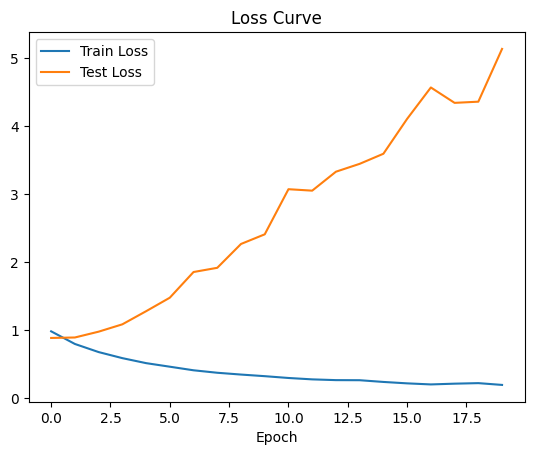

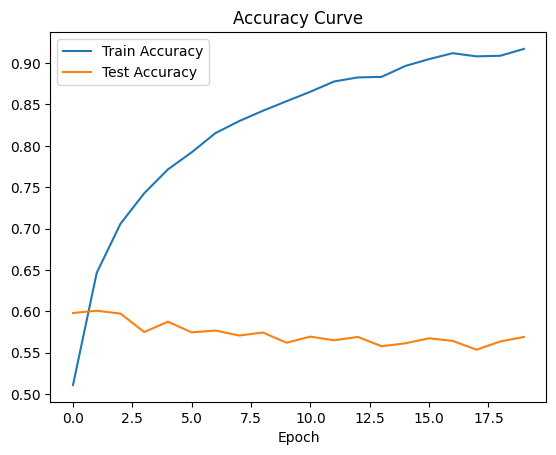

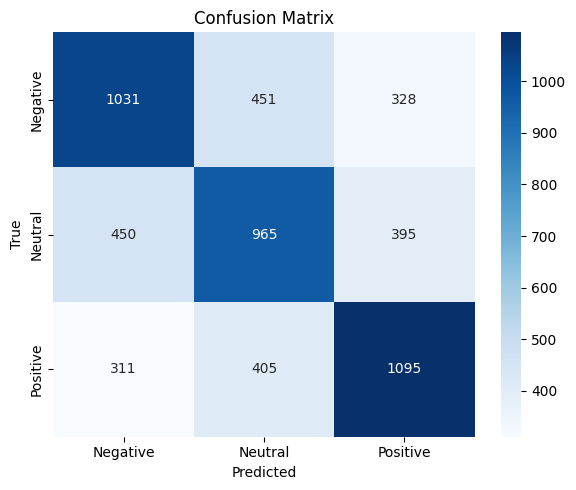

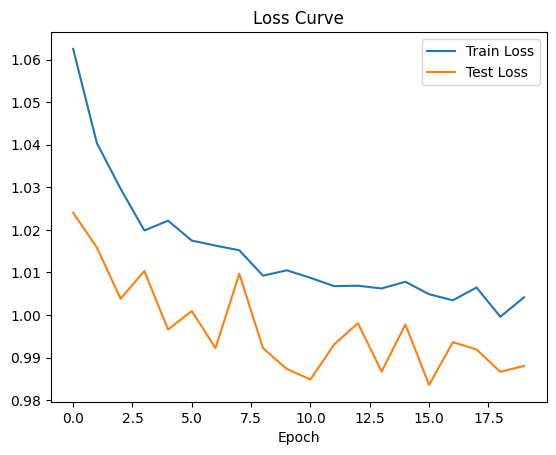

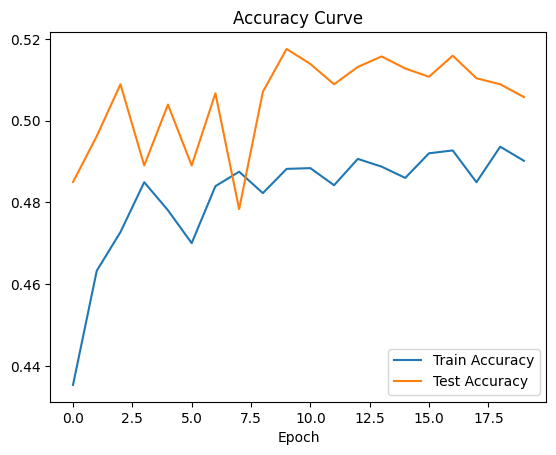

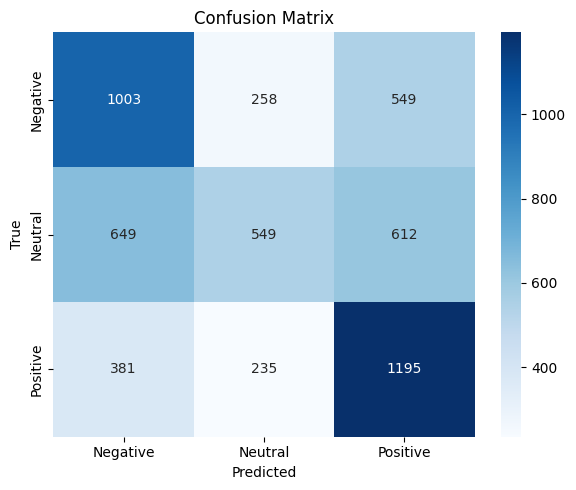

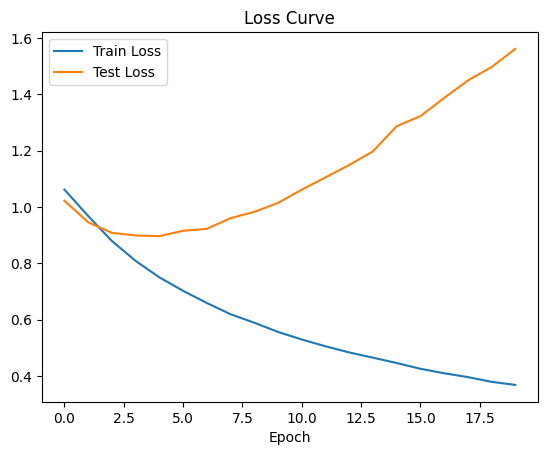

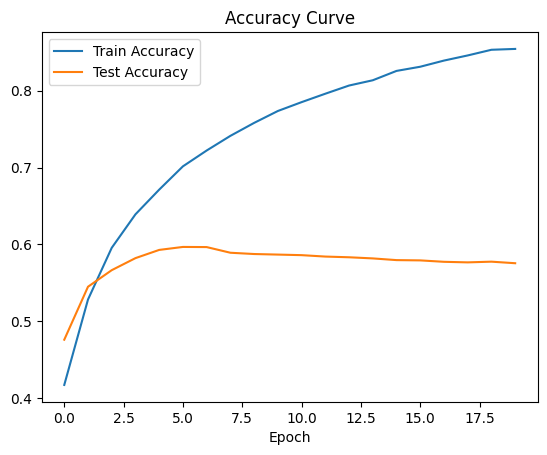

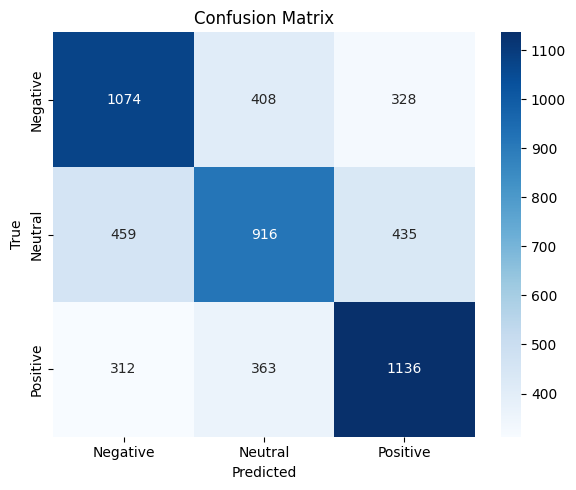

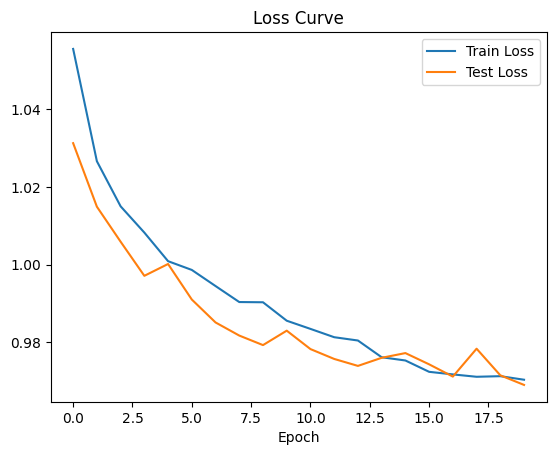

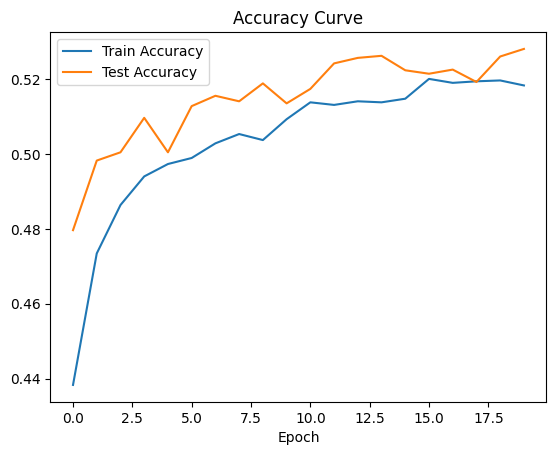

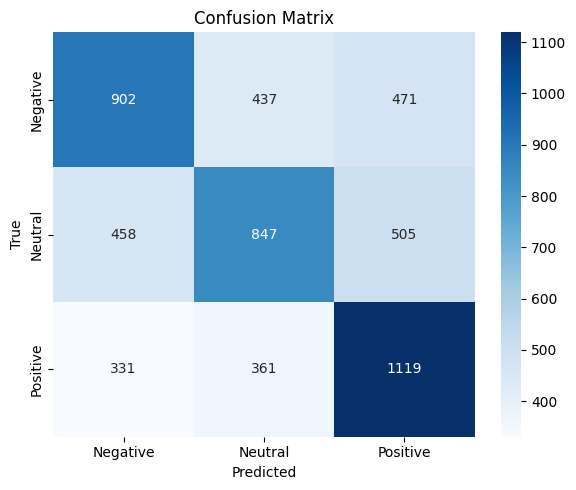

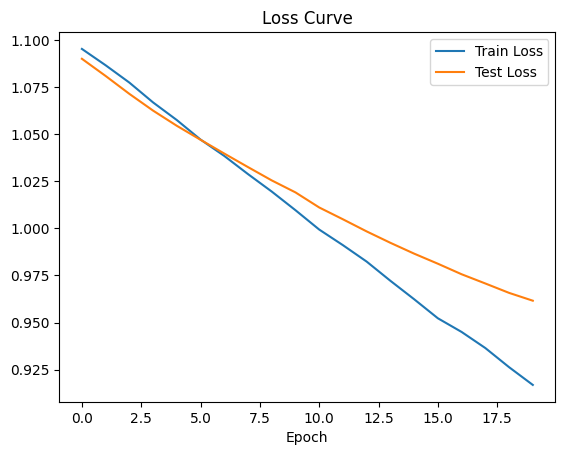

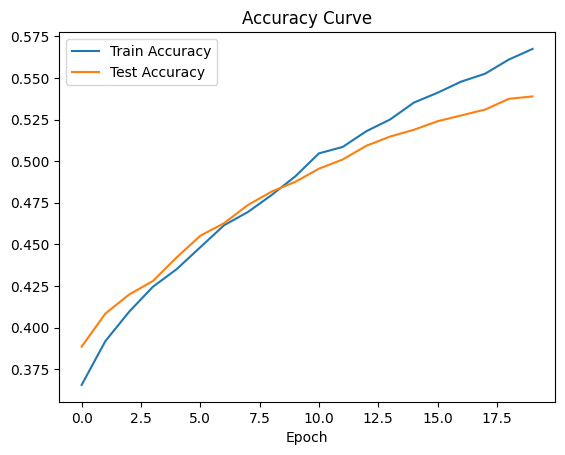

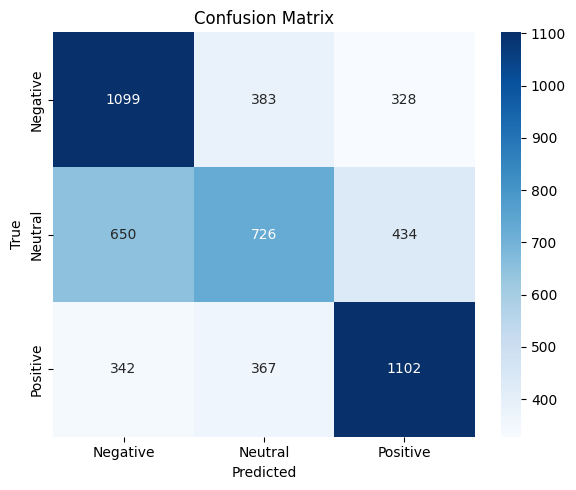

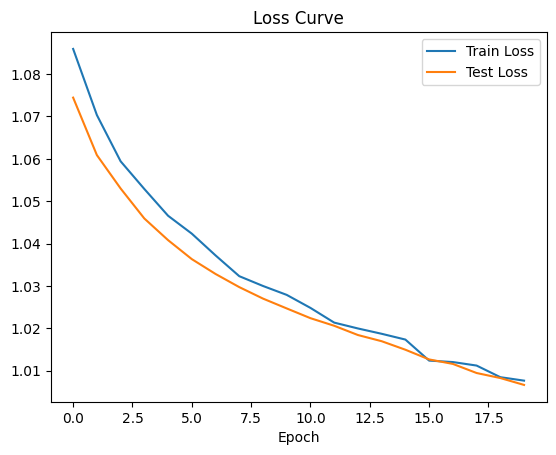

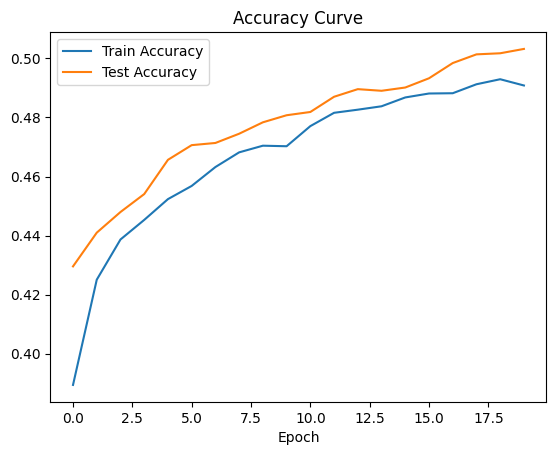

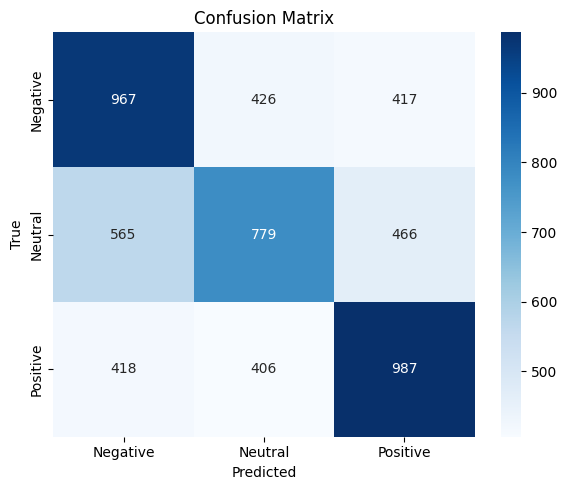

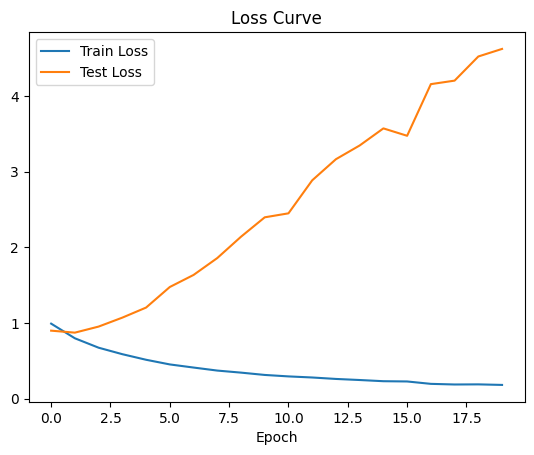

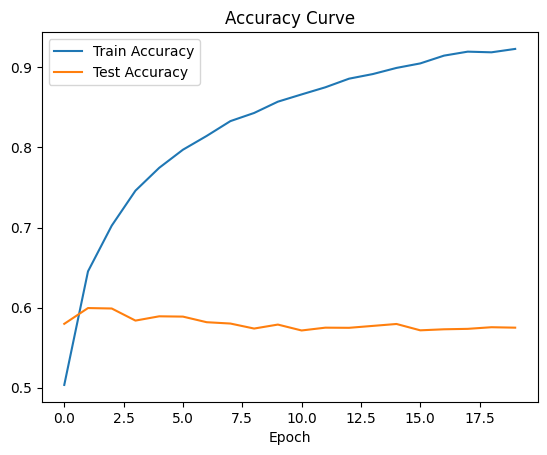

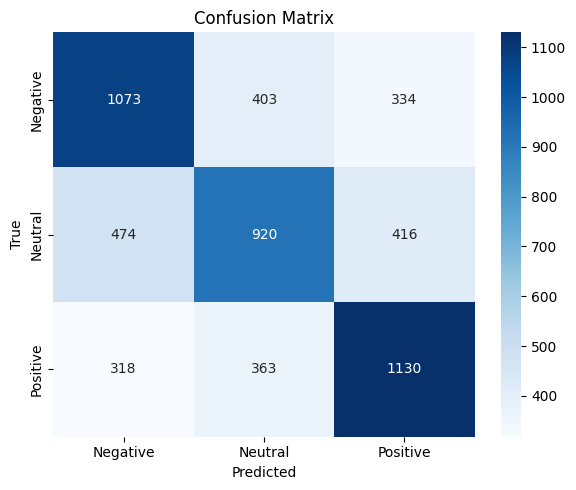

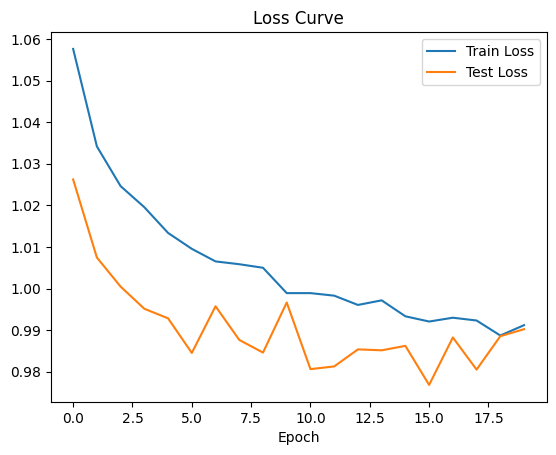

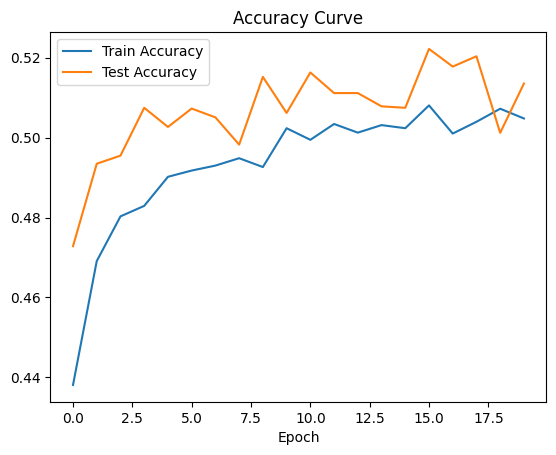

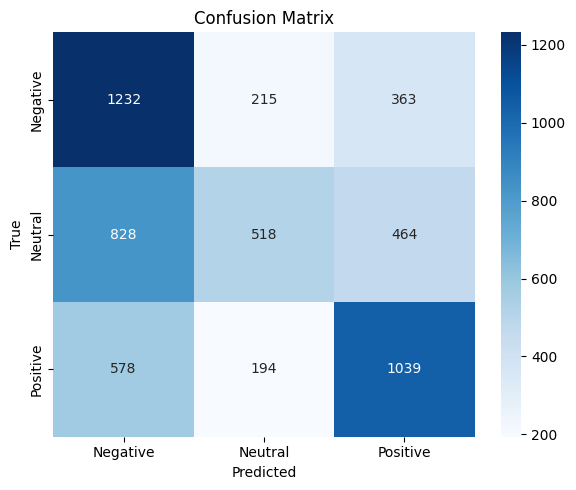

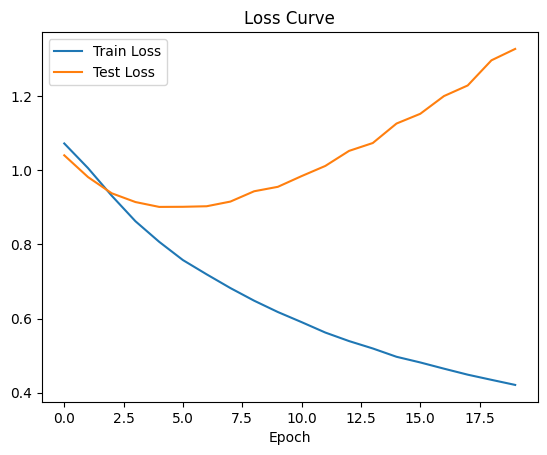

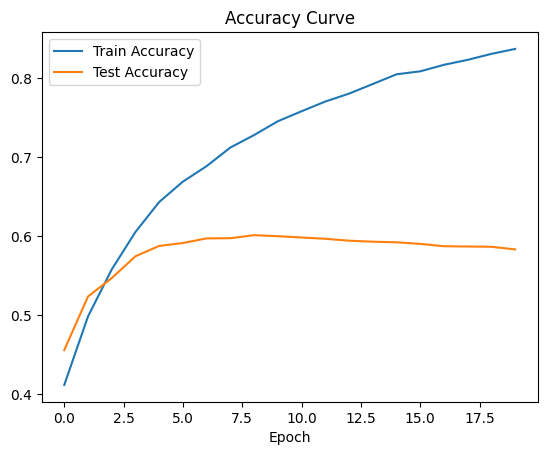

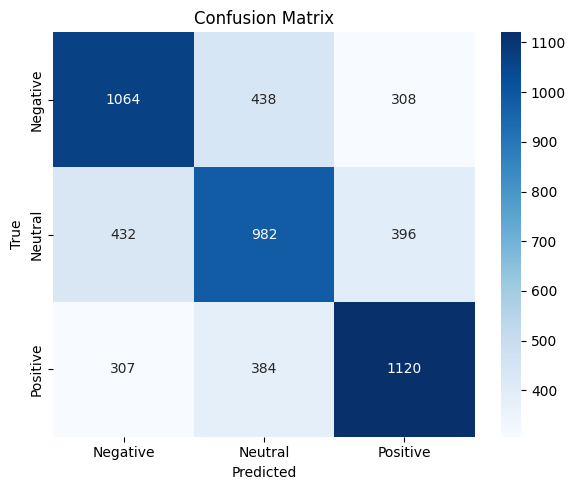

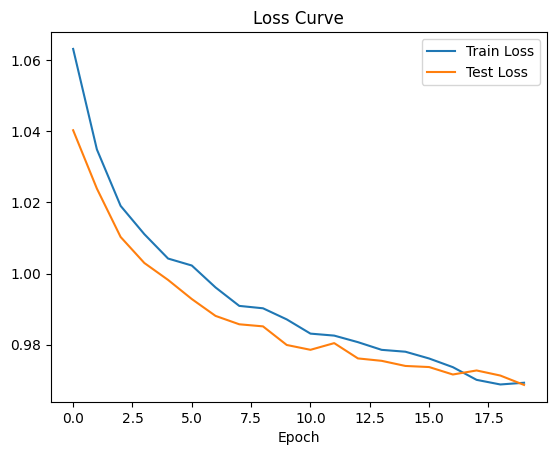

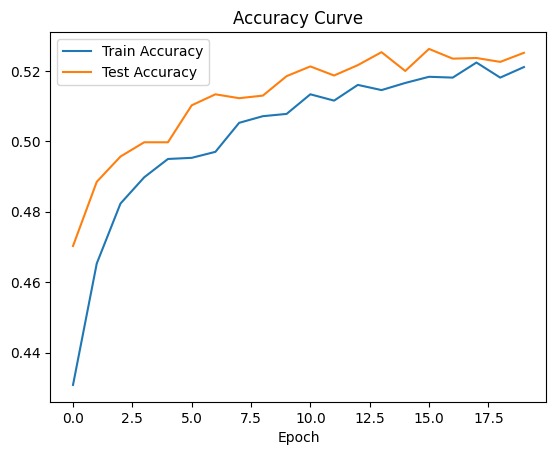

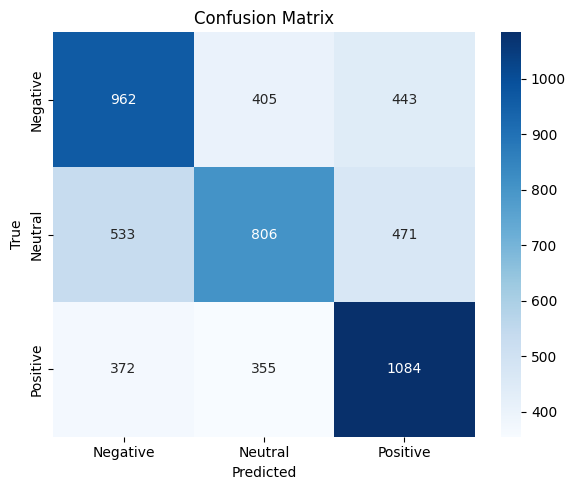

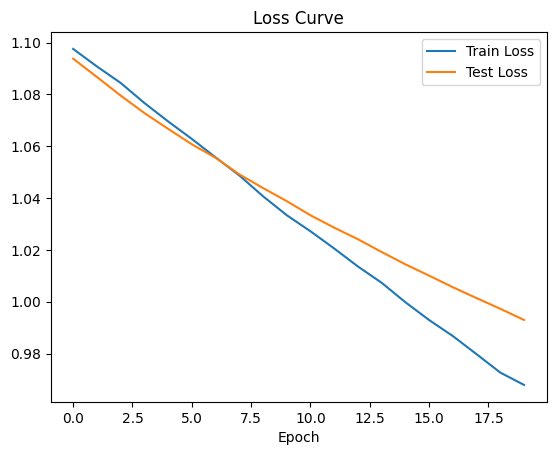

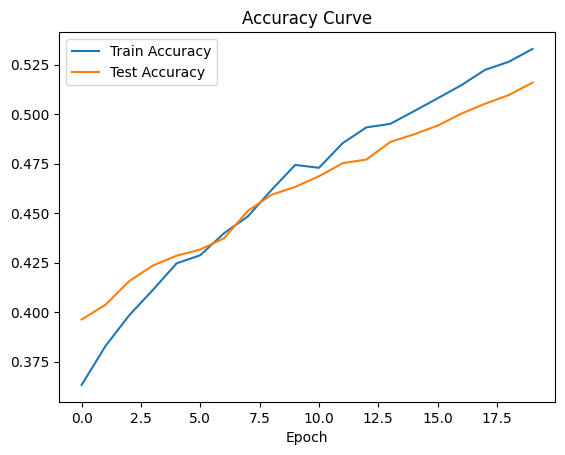

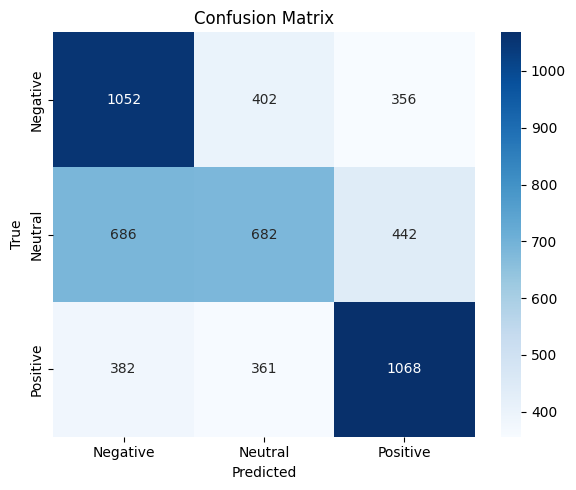

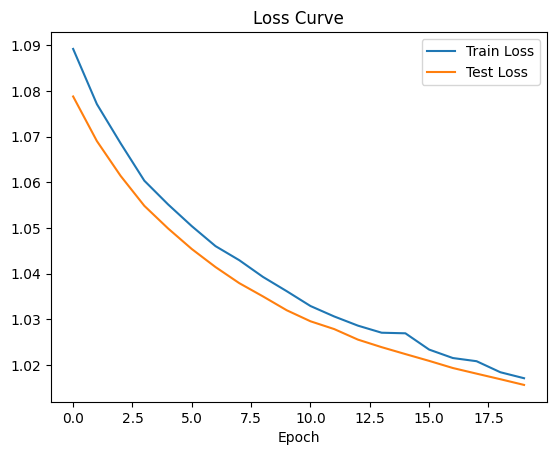

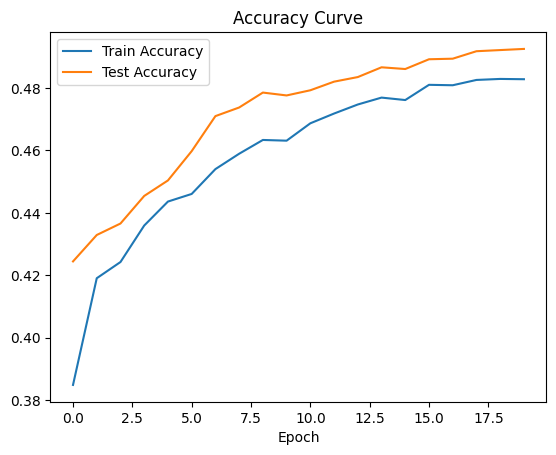

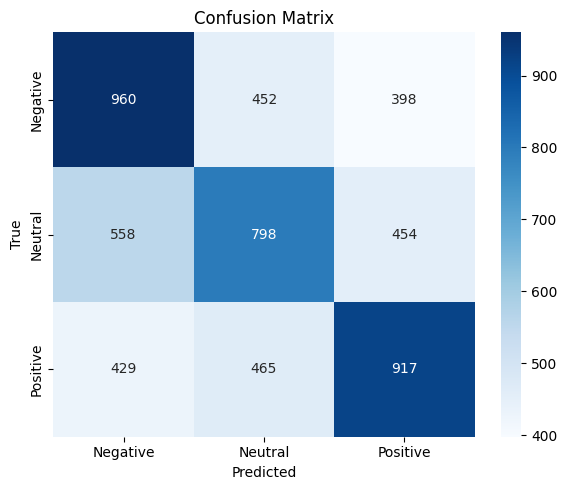

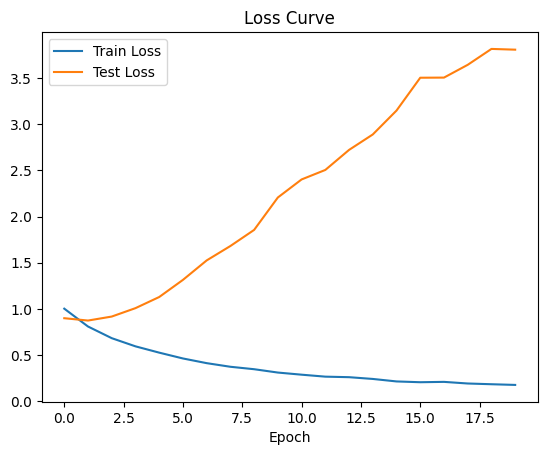

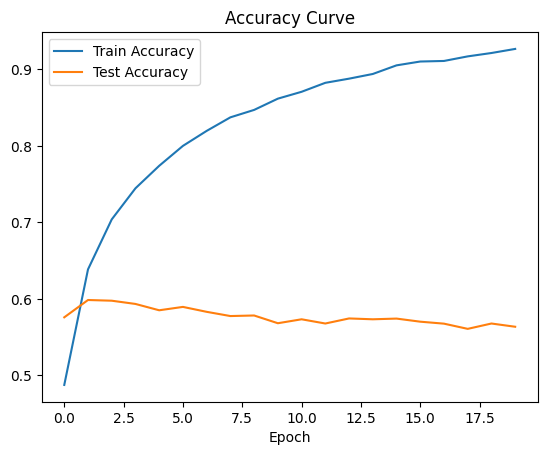

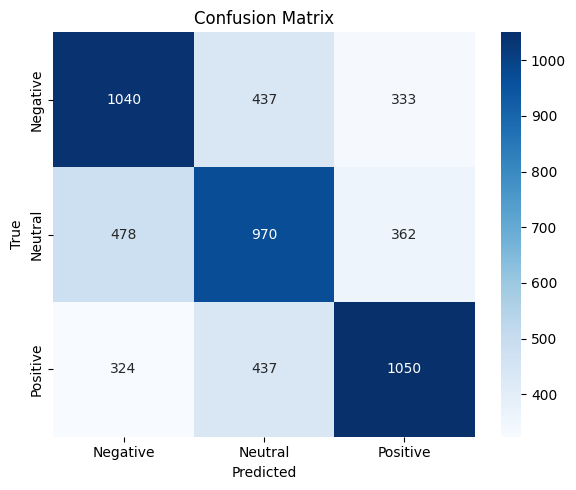

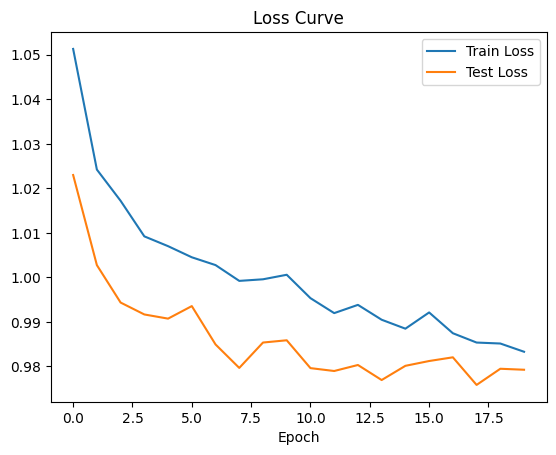

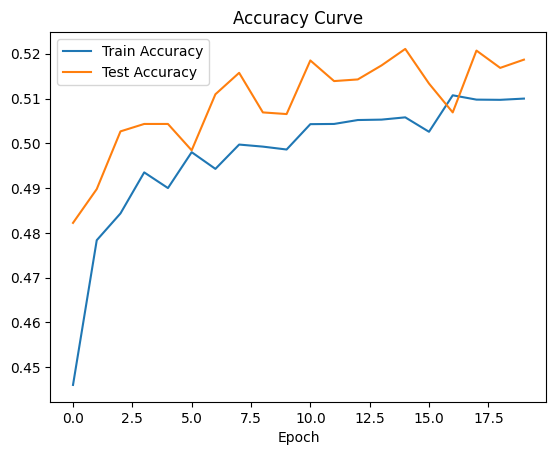

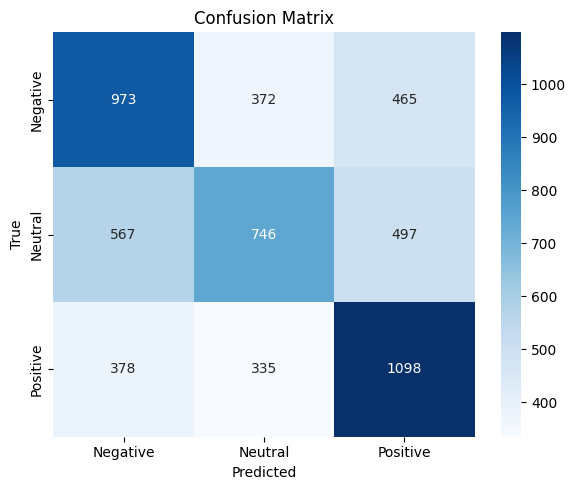

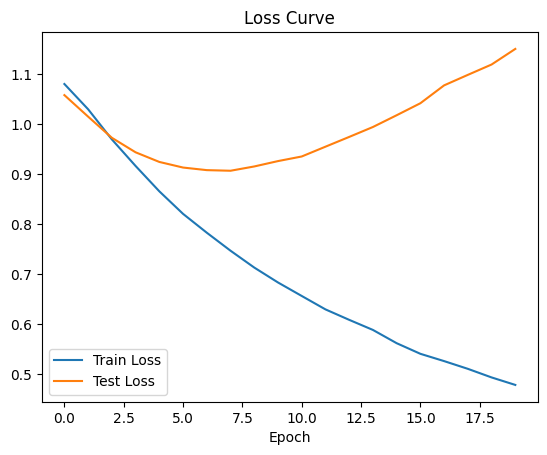

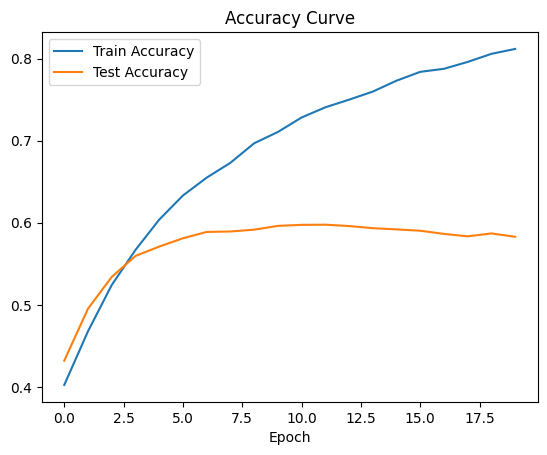

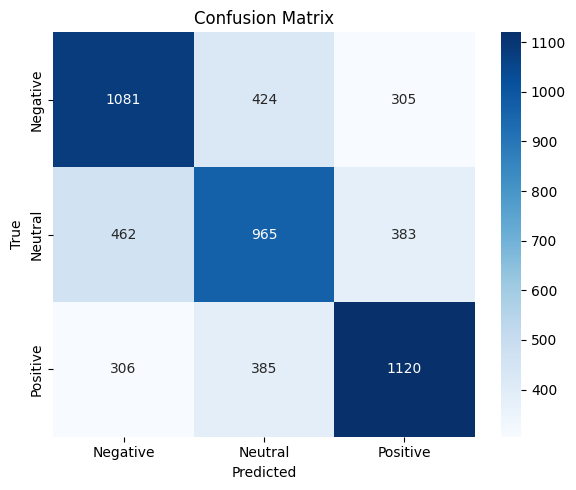

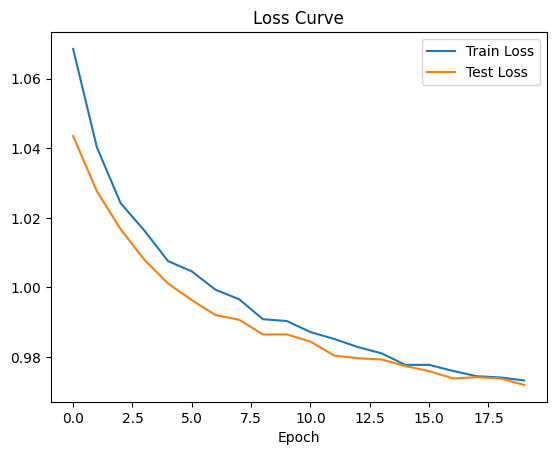

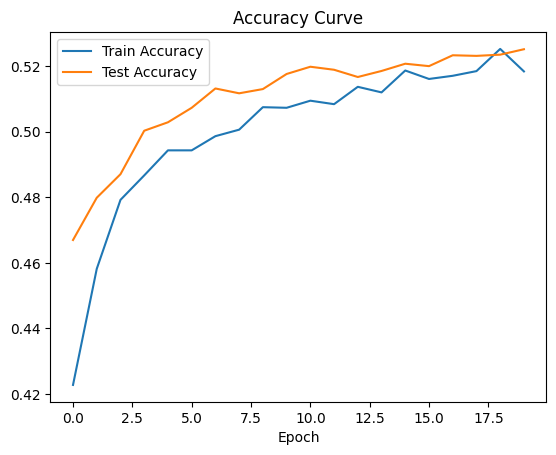

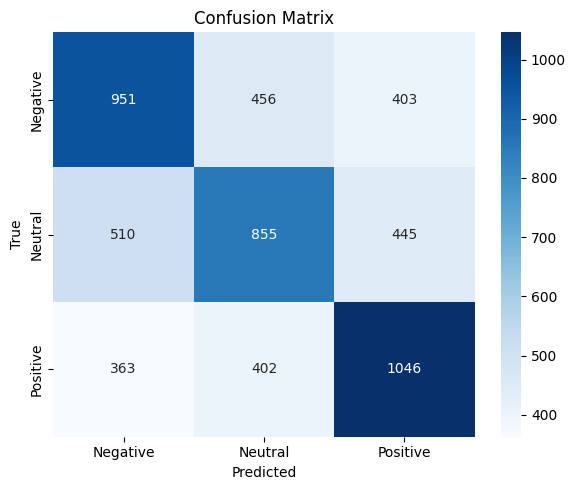

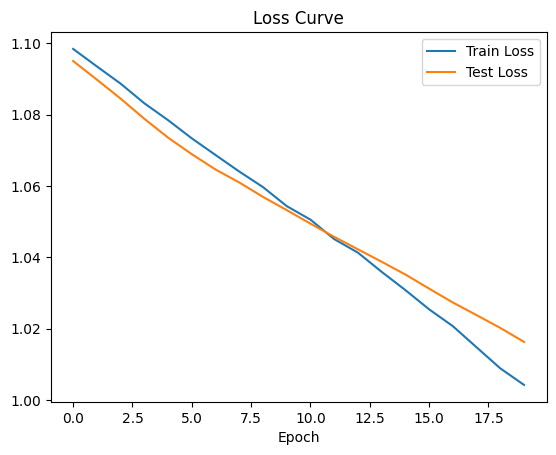

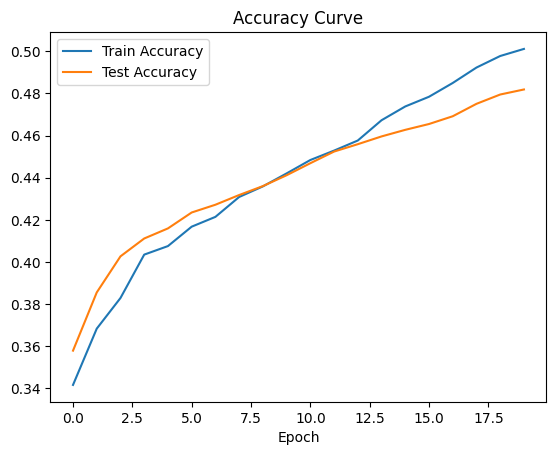

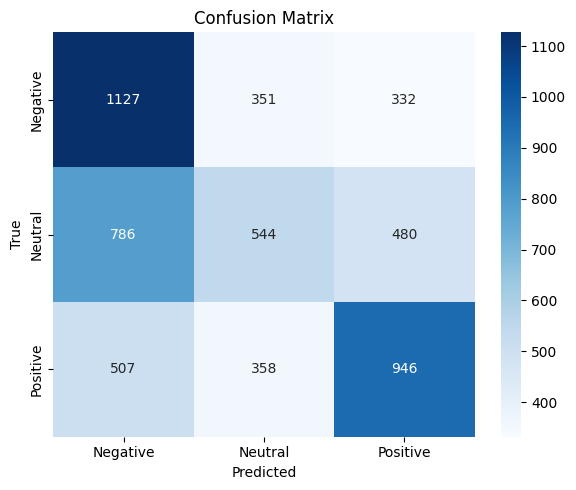

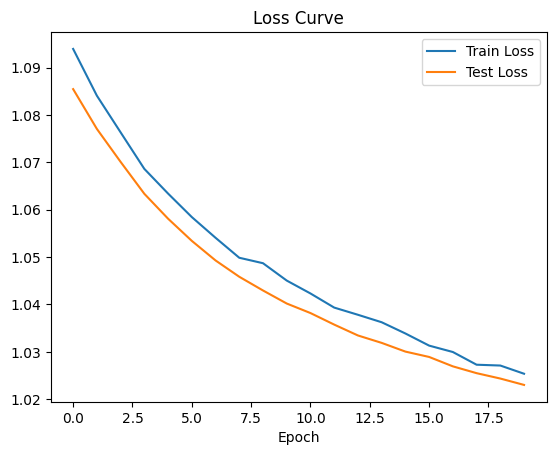

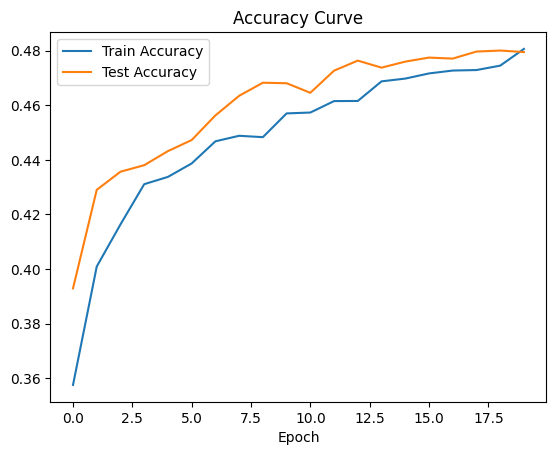

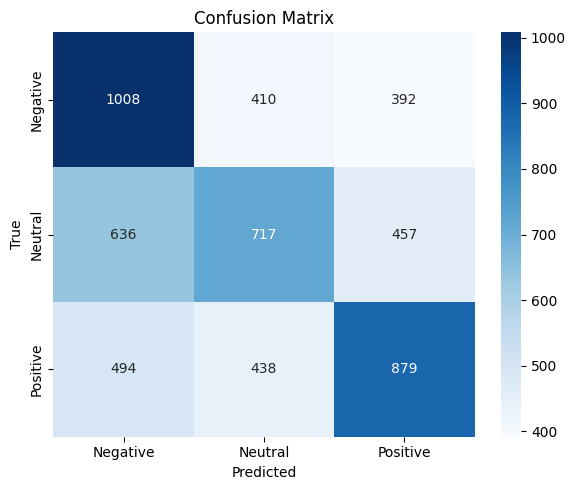

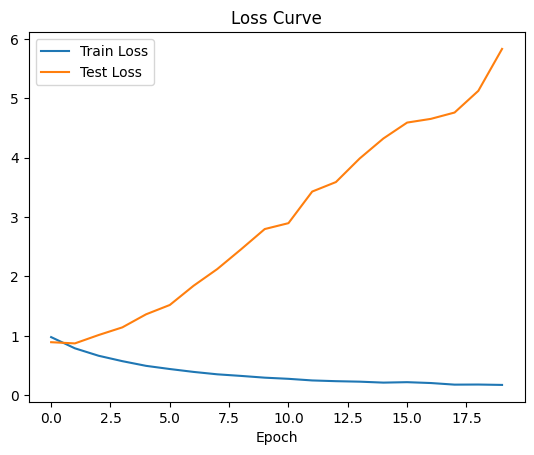

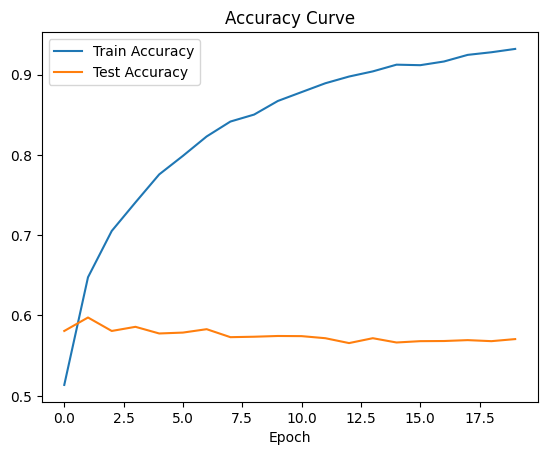

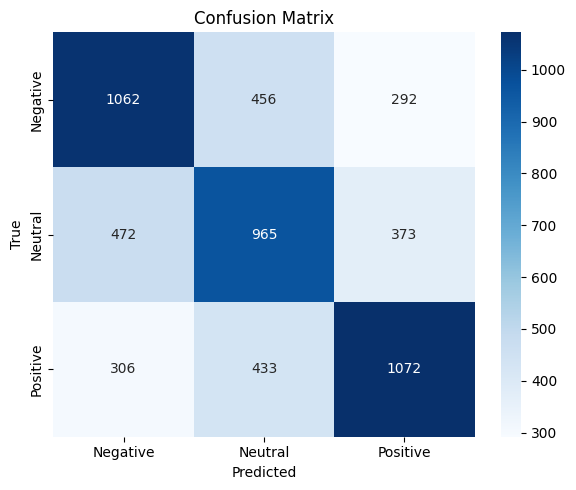

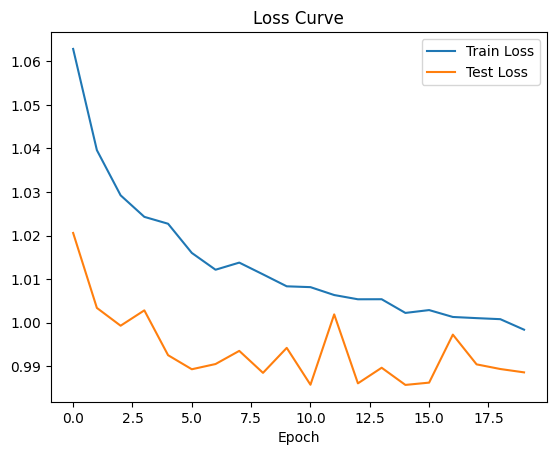

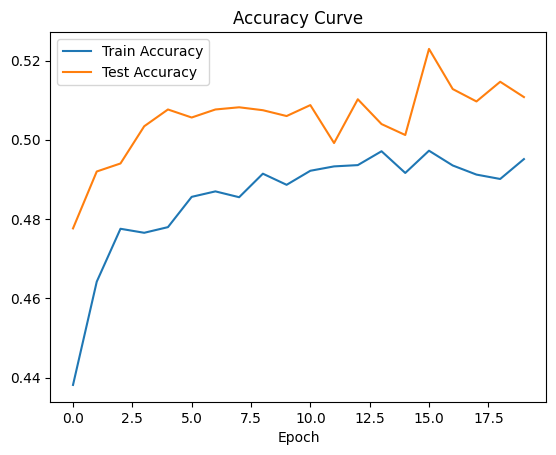

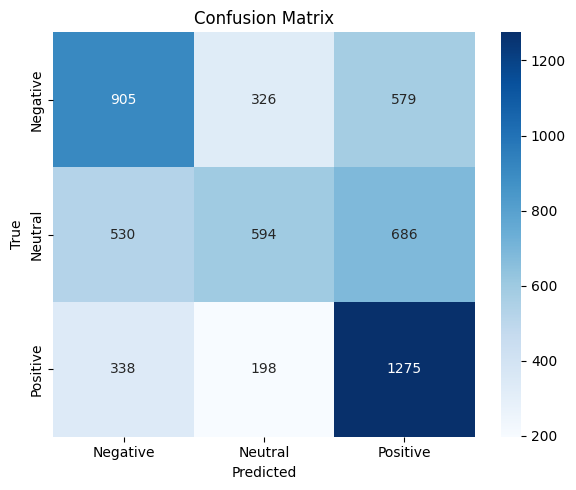

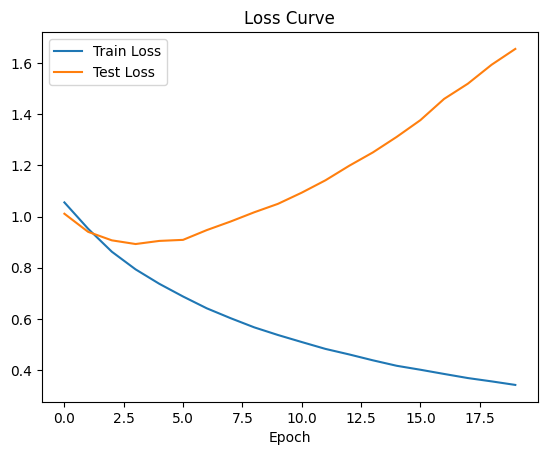

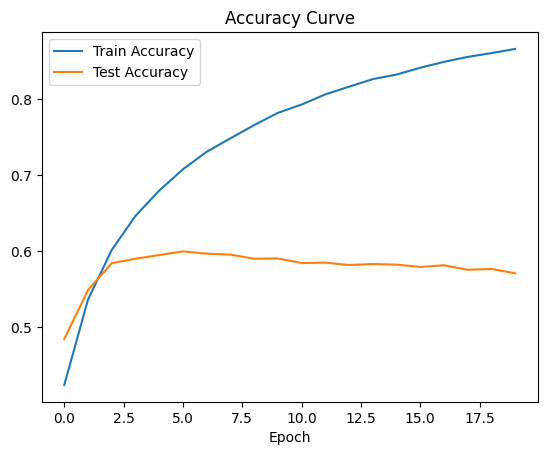

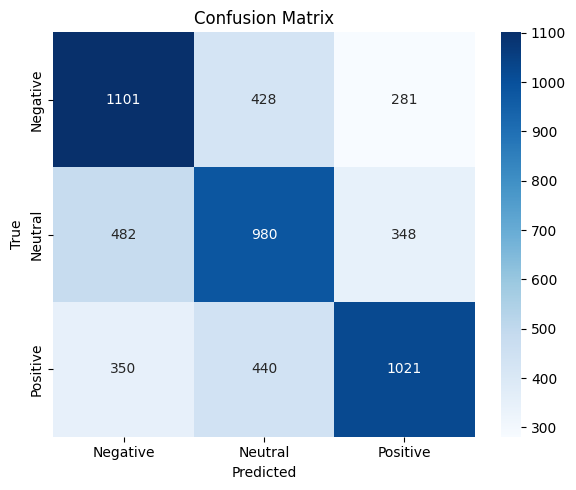

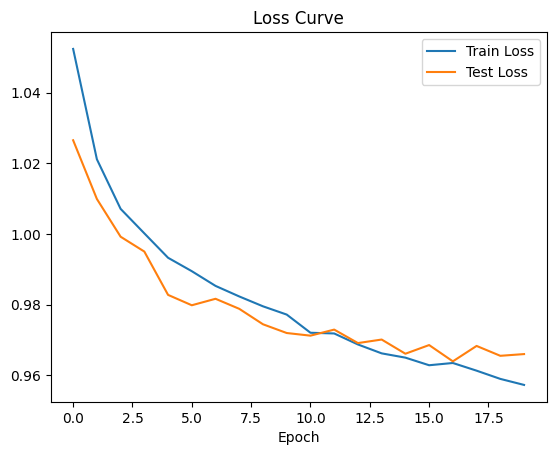

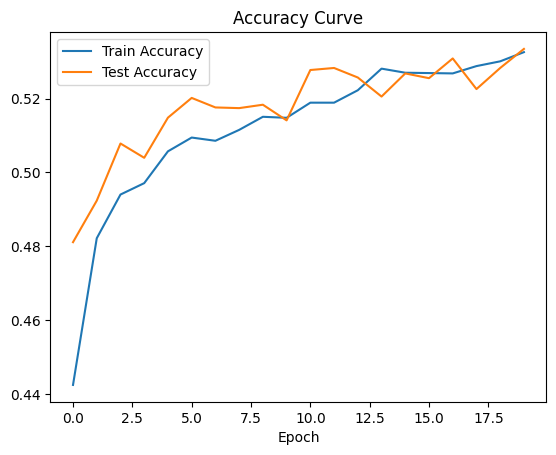

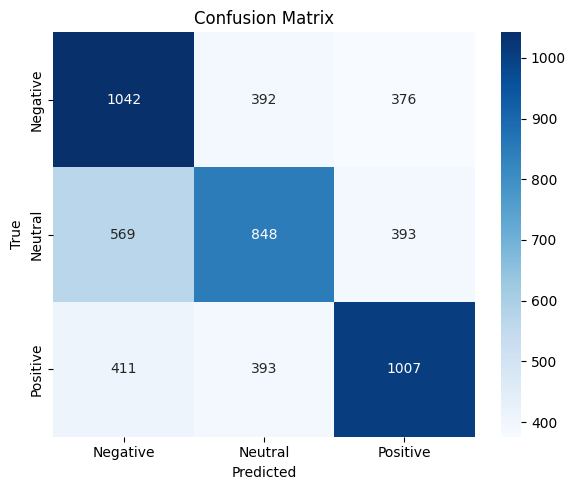

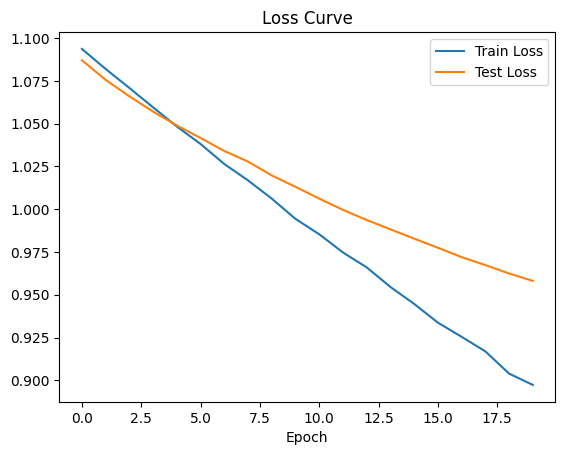

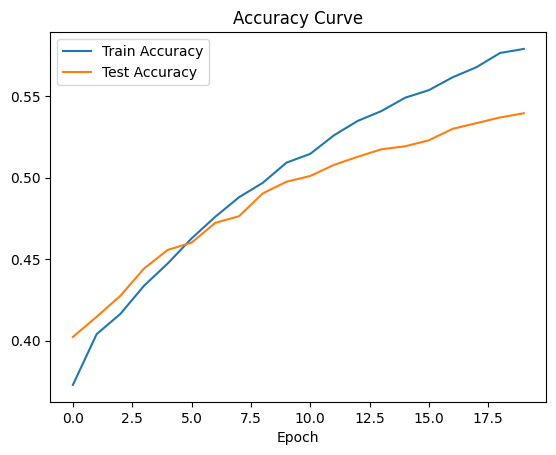

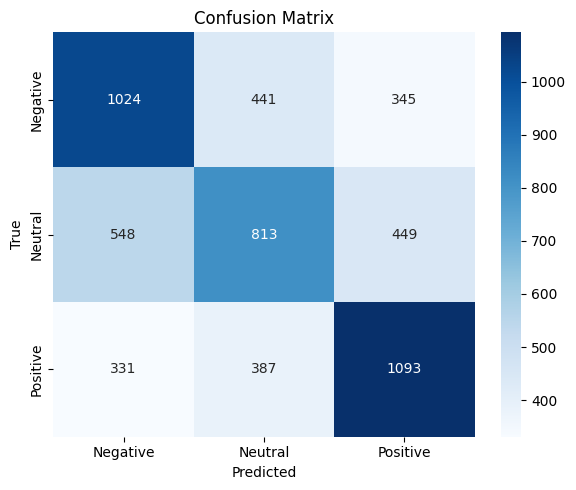

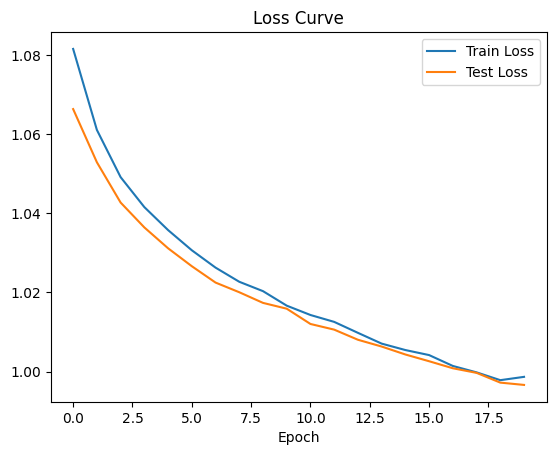

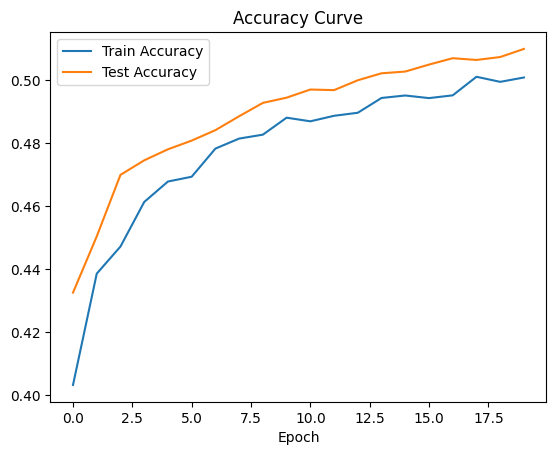

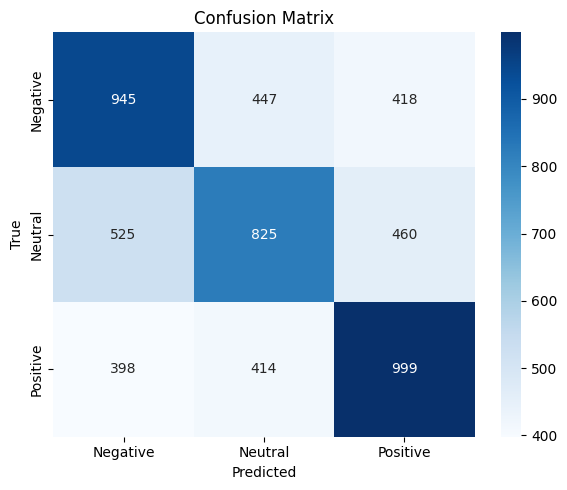

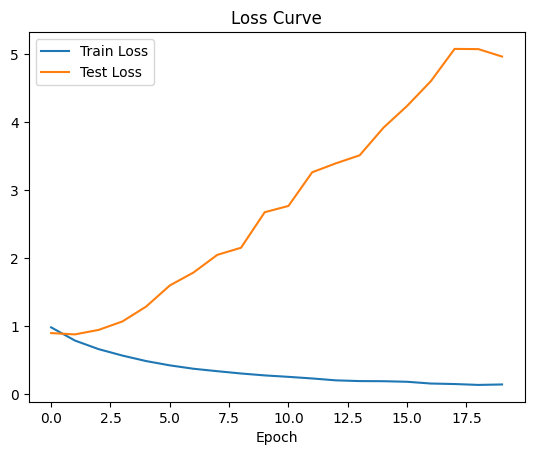

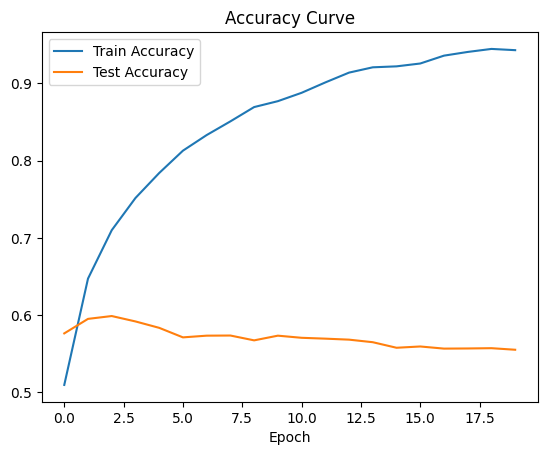

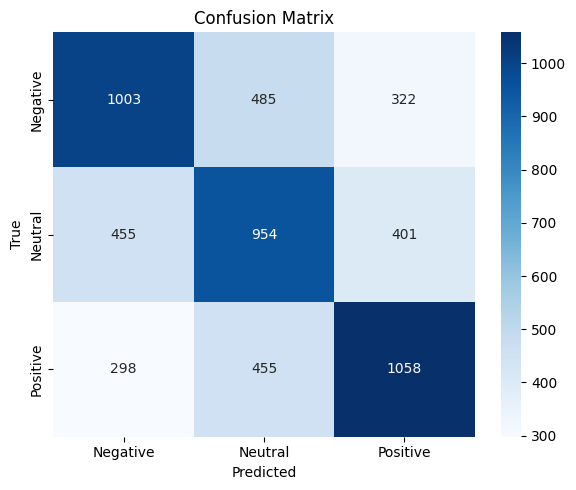

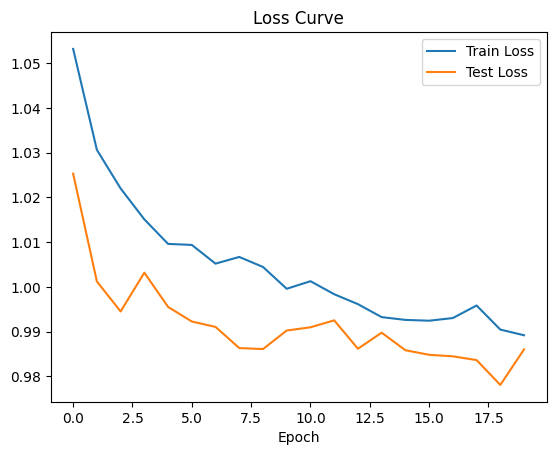

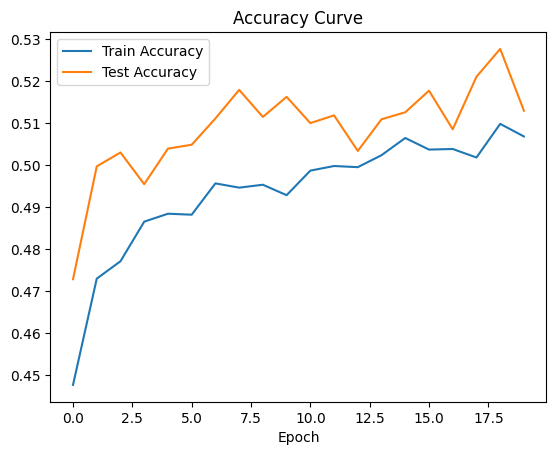

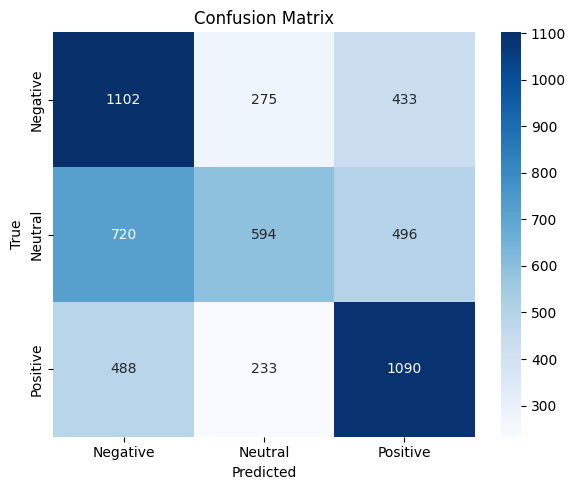

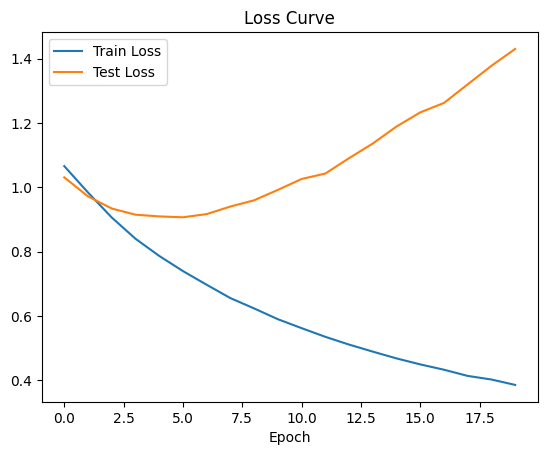

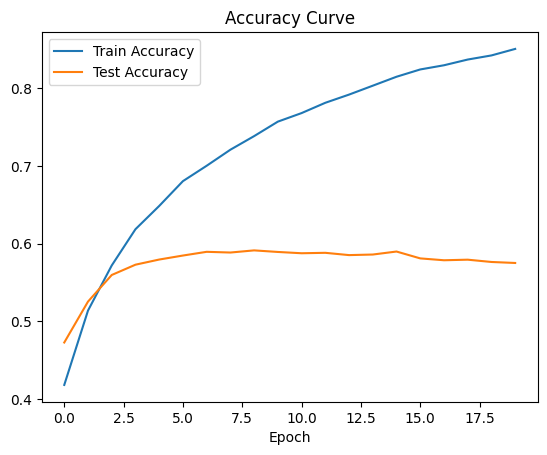

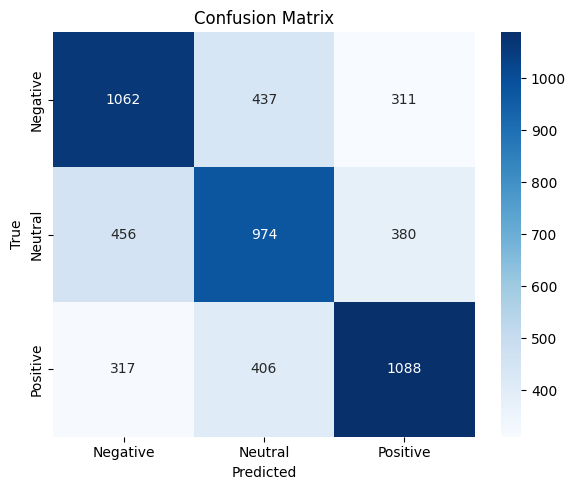

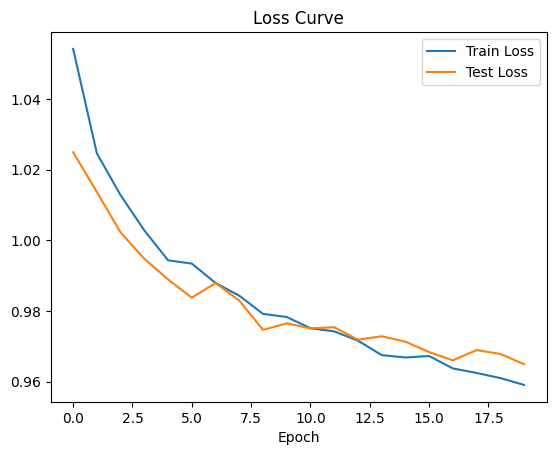

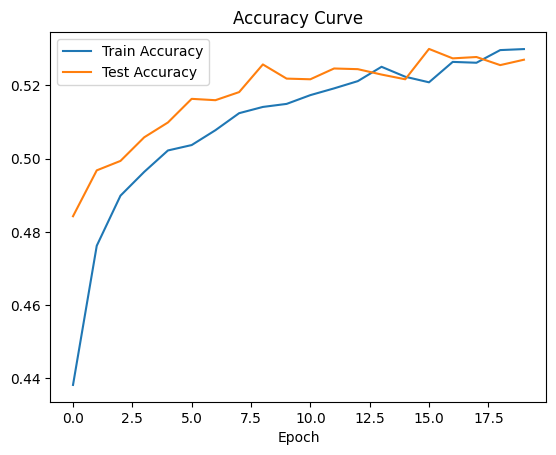

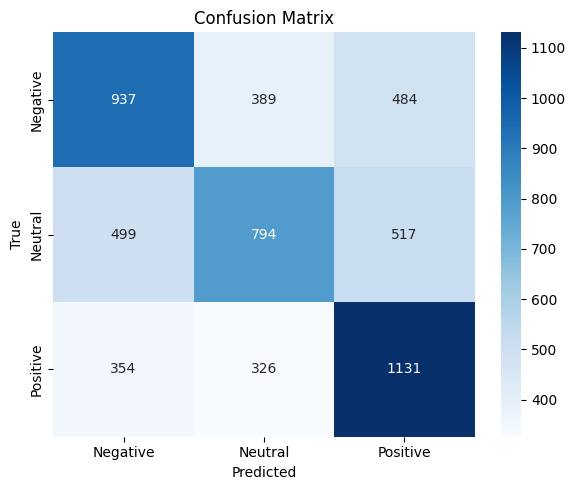

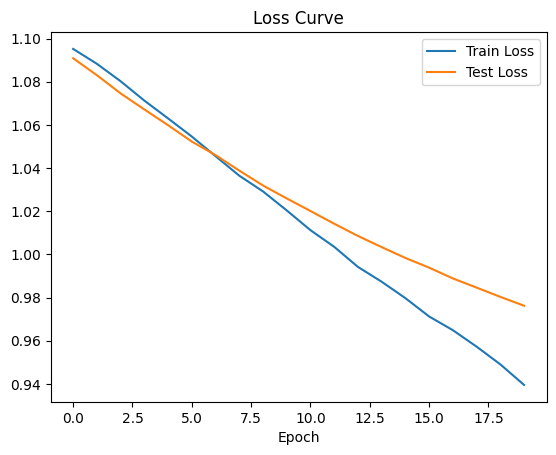

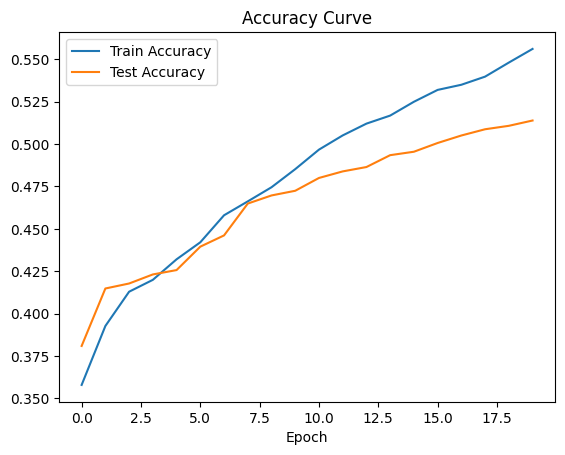

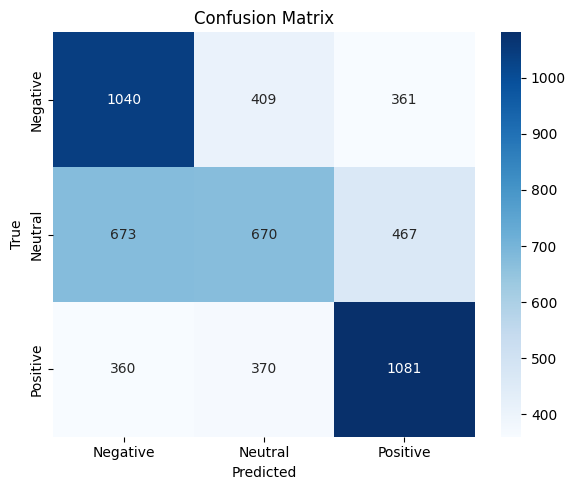

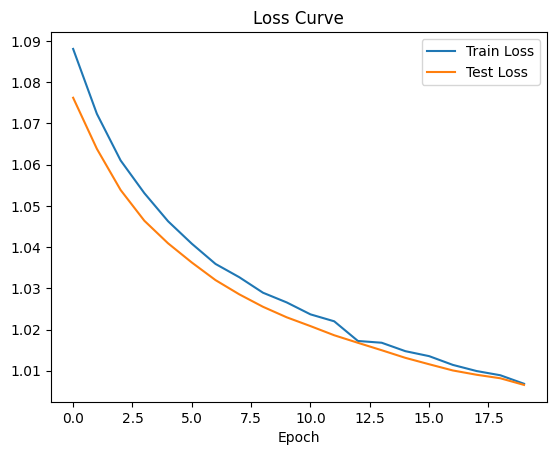

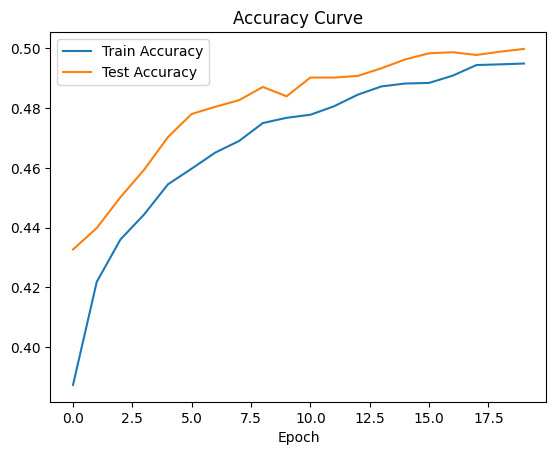

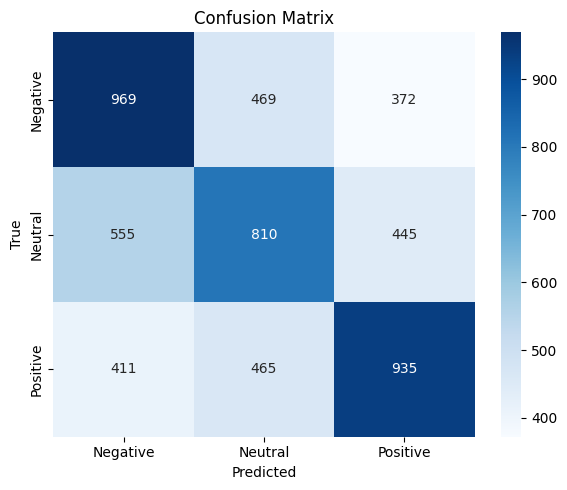

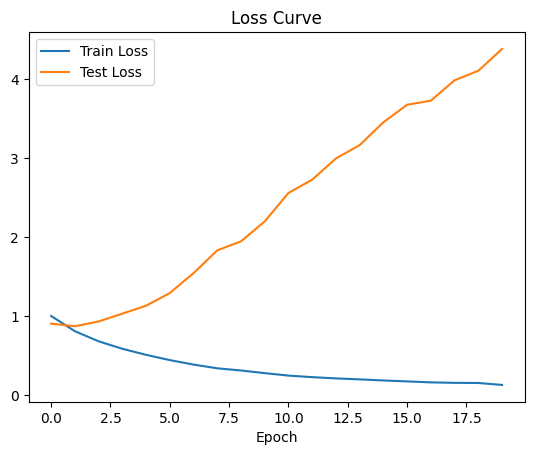

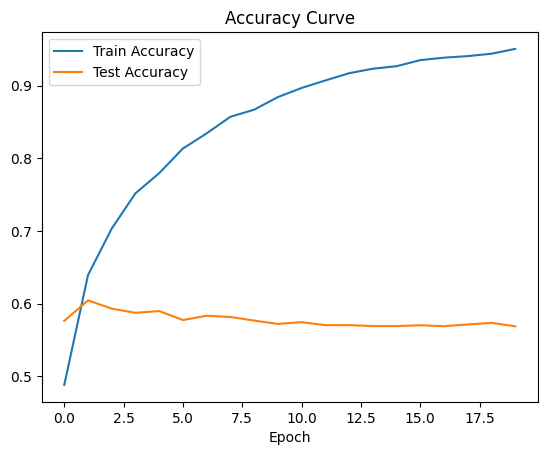

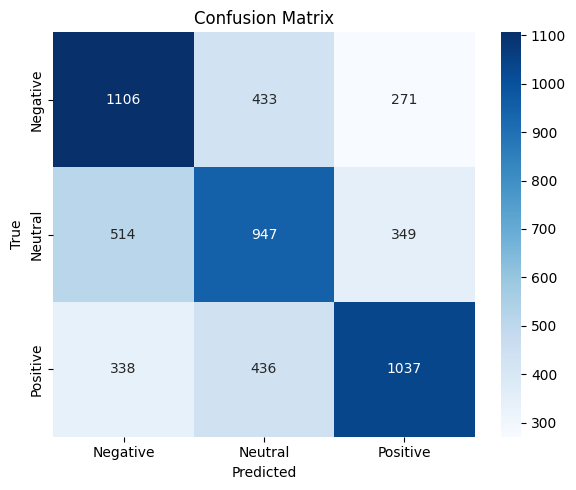

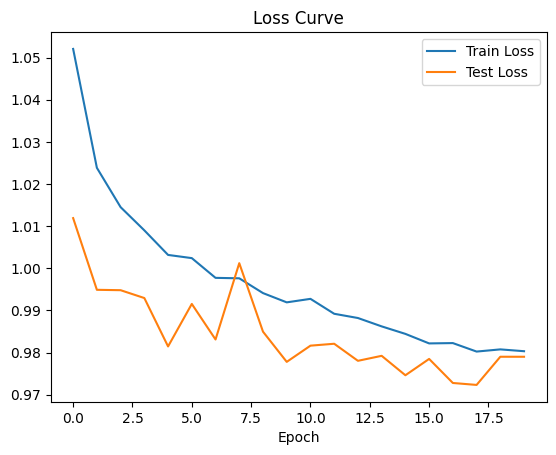

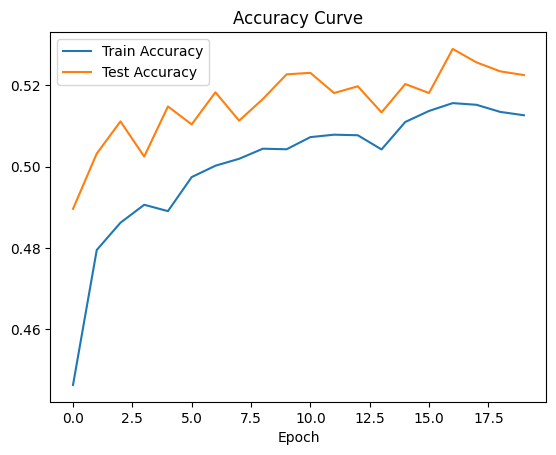

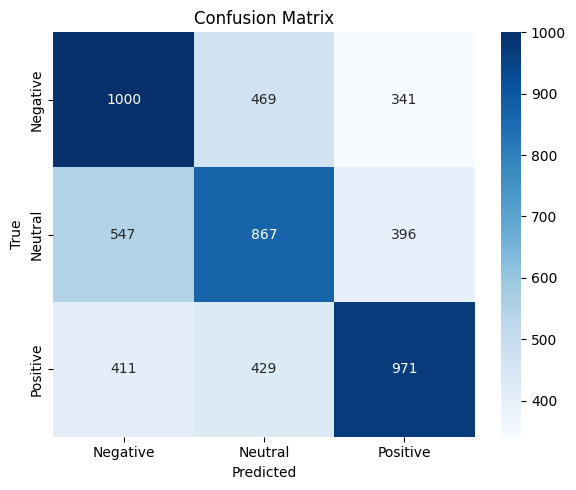

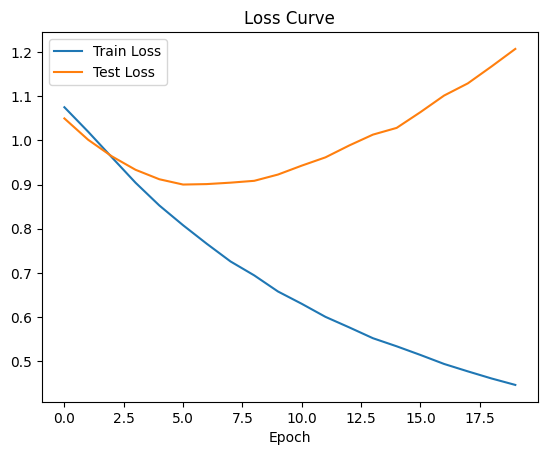

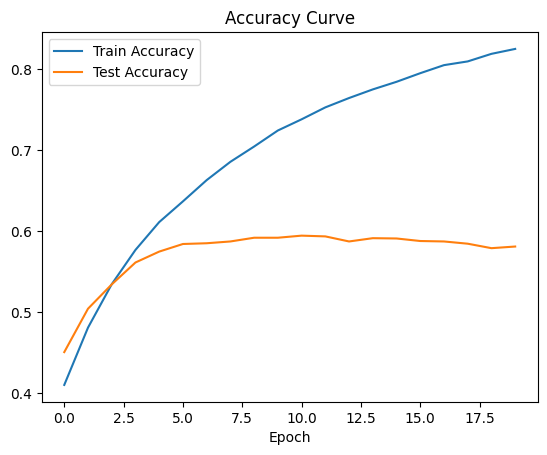

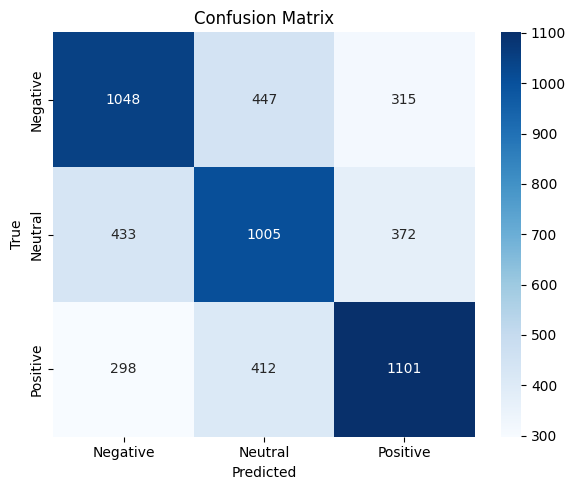

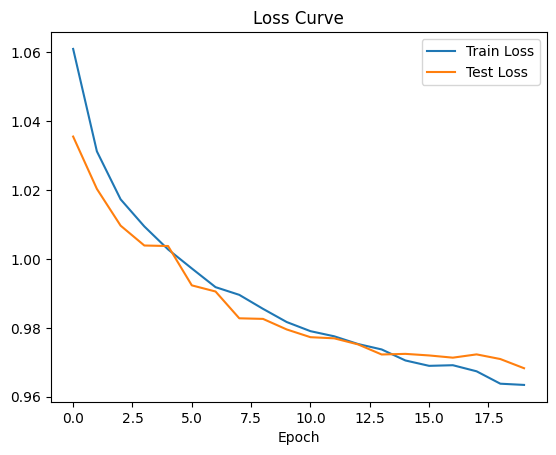

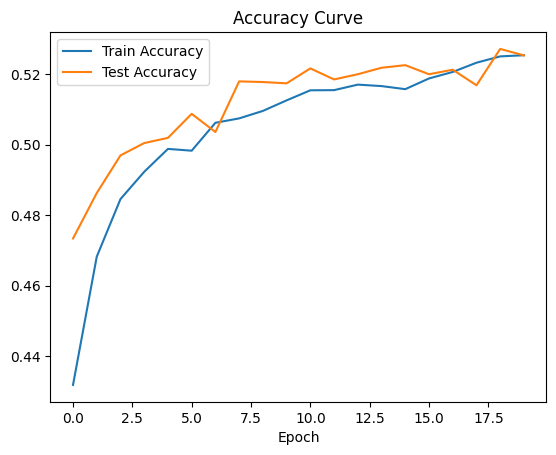

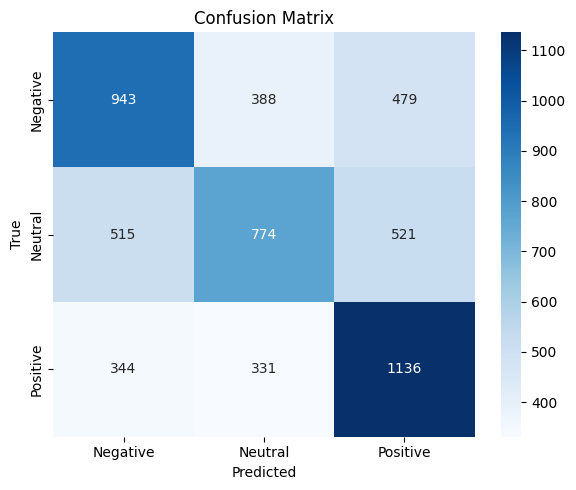

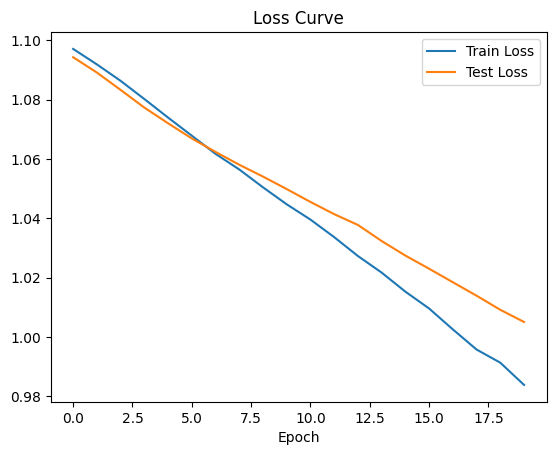

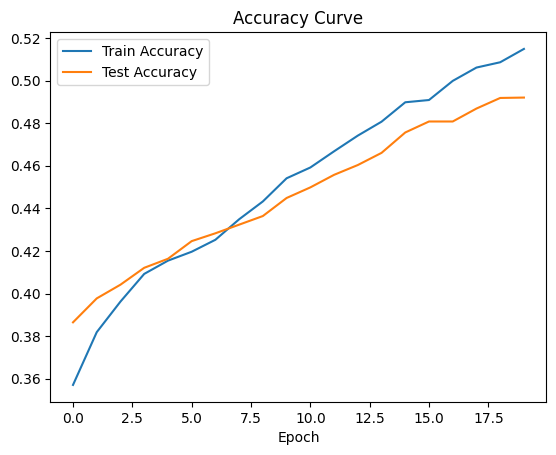

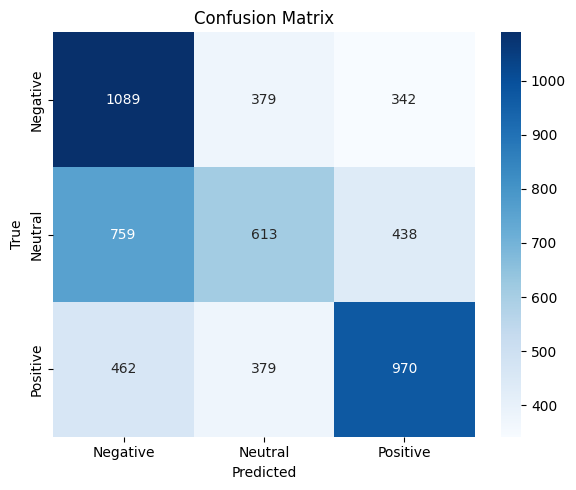

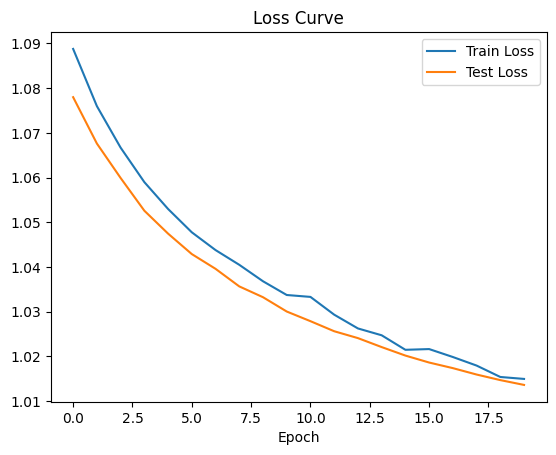

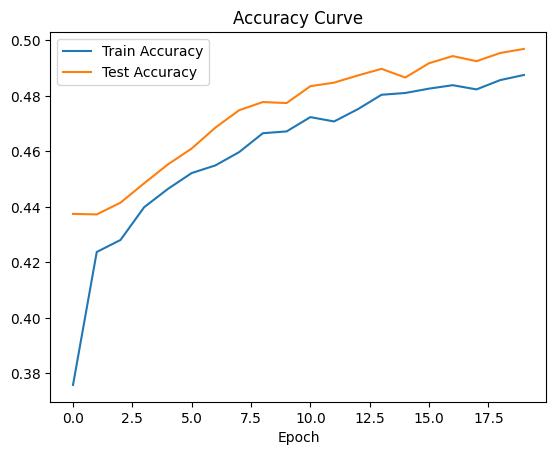

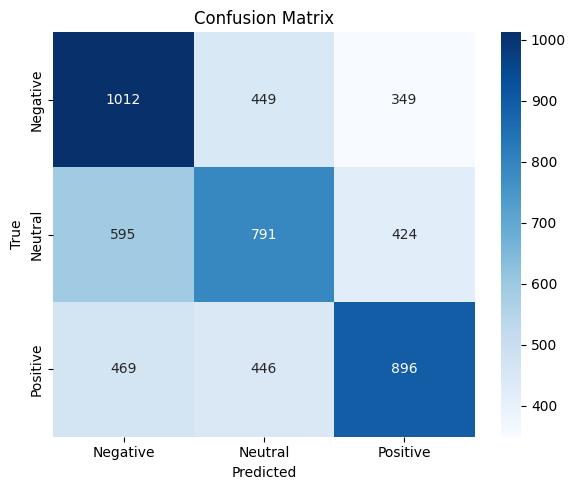

In [13]:
le = LabelEncoder()
le.fit(df["clean_label"])

hidden_sizes = [128, 256]
batch_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
embedding_types = ['nn', 'fasttext']

all_results = []
configs = list(product(hidden_sizes, batch_sizes, learning_rates, embedding_types))

for hs, bs, lr, emb in configs:
    config = {
        "hidden_size": hs,
        "batch_size": bs,
        "learning_rate": lr,
        "embedding_type": emb
    }
    print(f"Running config: {config}")

    # The train_and_evaluate function returns only one value (result).
    # Change the line below to receive only one value.
    result = train_and_evaluate(config, df.copy(), le)
    all_results.append(result)

df_results = pd.DataFrame(all_results)
df_results.to_csv("results_summary_sampled.csv", index=False)
print("All experiments complete. Summary saved to results_summary.csv")

In [14]:
def predict_unlabeled_texts(model_path, raw_texts, tokenizer=nltk_tokenizer, max_len=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.serialization.safe_globals([ndarray]):
        checkpoint = torch.load(model_path, weights_only=False)

    config = checkpoint['config']
    vocab = checkpoint['vocab']
    le = LabelEncoder()
    le.classes_ = checkpoint['label_encoder_classes']

    # Prepare embeddings if FastText is used
    ft_model = None
    if config['embedding_type'] == 'fasttext':
        tokenized = [tokenizer(t) for t in raw_texts]
        ft_model = FastText(sentences=tokenized, vector_size=100, window=5, min_count=1, epochs=5)

    dummy_labels = [0] * len(raw_texts)

    data = SentimentDataset(
        raw_texts, dummy_labels, vocab=vocab, tokenizer=tokenizer,
        max_len=max_len, embedding_type=config['embedding_type'], embed_model=ft_model
    )
    loader = DataLoader(data, batch_size=1)

    # Load model with dropout
    model = SentimentModel(
        vocab_size=len(vocab),
        embed_dim=100,
        hidden_dim=config['hidden_size'],
        num_classes=len(le.classes_),
        use_embedding=(config['embedding_type'] == 'nn'),
        dropout=config.get('dropout', 0.5)  # Include dropout parameter
    ).to(device)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    predictions = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            pred = model(x).argmax(1).item()
            predictions.append(le.inverse_transform([pred])[0])

    for text, pred in zip(raw_texts, predictions):
        print(f"Text: {text}\nPredicted Sentiment: {pred}\n")


In [15]:
unlabeled_texts = [
    "Markets rallied today on strong earnings reports",
    "Investors are worried about rising inflation",
    "The economic outlook remains uncertain",
    "Tech stocks soared after a positive forecast",
    "The company faces legal troubles over its latest product",
    "Donald Trump has a positive feature about investment in Iran",
    "Saving money is a very good idea",
    "I am gonna save my money to becom a rich man"
]

model_path = "models_sampled/model_hs256_bs128_lr0.001_embnn.pt"

predict_unlabeled_texts(model_path, unlabeled_texts)

Text: Markets rallied today on strong earnings reports
Predicted Sentiment: Positive

Text: Investors are worried about rising inflation
Predicted Sentiment: Neutral

Text: The economic outlook remains uncertain
Predicted Sentiment: Neutral

Text: Tech stocks soared after a positive forecast
Predicted Sentiment: Positive

Text: The company faces legal troubles over its latest product
Predicted Sentiment: Positive

Text: Donald Trump has a positive feature about investment in Iran
Predicted Sentiment: Positive

Text: Saving money is a very good idea
Predicted Sentiment: Positive

Text: I am gonna save my money to becom a rich man
Predicted Sentiment: Positive



In [16]:
import shutil
from IPython.display import FileLink

# Step 1: Zip the folder (replace 'my_folder' with your folder name)
shutil.make_archive('plots_sampled', 'zip', 'plots_sampled')

# Step 2: Provide a download link
FileLink('plots_sampled.zip')


/content/drive/.shortcut-targets-by-id/1uYfTSnfokWDeAv9-_LyZu5MGDLuJlF_n/Reddit_dataset/plots_sampled.zip